In [1]:
!pip install soundfile

In [3]:
!pip install numpy

In [4]:
!pip install matplotlib

     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     ------ ------------------------------ 30.7/162.8 kB 119.8 kB/s eta 0:00:02
     --------- --------------------------- 41.0/162.8 kB 131.3 kB/s eta 0:00:01
     ------------- ----------------------- 61.4/162.8 kB 204.8 kB/s eta 0:00:01
     ------------- ----------------------- 61.4/162.8 kB 204.8 kB/s eta 0:00:01
     ------------------ ------------------ 81.9/162.8 kB 191.1 kB/s eta 0:00:01
     ------------------ ------------------ 81.9/162.8 kB 191.1 kB/s eta 0:00:01
     

In [6]:
!pip install scipy

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.6 kB 131.3 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.6 kB 145.2 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.6 kB 151.3 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.6 kB 151.3 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/60.6 kB 154.0 kB/s eta 0:00:01
     -------------------------------------- 60.6/60.6 kB 153.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/45.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/45.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/45.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/45.9 MB ? eta -:--:--
   -------------------

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf

In [8]:
def my_xcorr2(x, y, scaleopt='none'):
    r""" Cross Correlation function phixy[kappa] -> x[k+kappa] y

    input:
    x   input signal shifted by +kappa
    y   input signal
    scaleopt   scaling of CCF estimator
    output:
    kappa   sample index
    ccf   correlation result
    """
    N = len(x)
    M = len(y)
    kappa = np.arange(0, N+M-1) - (M-1)
    ccf = signal.correlate(x, y, mode='full', method='auto')
    if N == M:
        if scaleopt == 'none' or scaleopt == 'raw':
            ccf /= 1
        elif scaleopt == 'biased' or scaleopt == 'bias':
            ccf /= N
        elif scaleopt == 'unbiased' or scaleopt == 'unbias':
            ccf /= (N - np.abs(kappa))
        elif scaleopt == 'coeff' or scaleopt == 'normalized':
            ccf /= np.sqrt(np.sum(x**2) * np.sum(y**2))
        else:
            print('scaleopt unknown: we leave output unnormalized')
    return kappa, ccf

In [9]:
def uniform_midtread_quantizer(x, deltaQ):
    r"""uniform_midtread_quantizer from the lecture:
    https://github.com/spatialaudio/digital-signal-processing-lecture/blob/master/quantization/linear_uniform_quantization_error.ipynb
    commit: b00e23e
    note: we renamed the second input to deltaQ, since this is what the variable
    actually represents, i.e. the quantization step size

    input:
    x   input signal to be quantized
    deltaQ    quantization step size
    output:
    xq   quantized signal
    """
    # [-1...1) amplitude limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - deltaQ)
    x[idx] = 1 - deltaQ
    # linear uniform quantization
    xq = deltaQ * np.floor(x/deltaQ + 1/2)
    return xq

In [10]:
def my_quant(x, Q):
    r"""Saturated uniform midtread quantizer

    input:
    x  input signal
    Q  number of quantization steps
    output:
    xq quantized signal

    Note: for even Q in order to retain midtread characteristics,
    we must omit one quantization step, either that for lowest or the highest
    amplitudes. Typically the highest signal amplitudes are saturated to
    the 'last' quantization step. Then, in the special case of log2(N)
    being an integer the quantization can be represented with bits.
    """
    tmp = Q//2  # integer div
    quant_steps = (np.arange(Q) - tmp) / tmp

    # forward quantization, round() and inverse quantization
    xq = np.round(x*tmp) / tmp
    # always saturate to -1
    xq[xq < -1.] = -1.
    # saturate to ((Q-1) - (Q\2)) / (Q\2), note that \ is integer div
    tmp2 = ((Q-1) - tmp) / tmp
    xq[xq > tmp2] = tmp2
    return xq

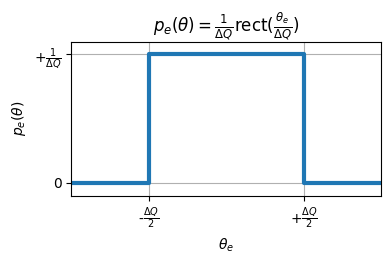

In [11]:
plt.figure(figsize=(4, 2))
plt.plot((-1, -1/2, -1/2, +1/2, +1/2, +1), (0, 0, 1, 1, 0, 0), lw=3)
plt.xlim(-1, 1)
plt.ylim(-0.1, 1.1)
plt.xticks((-0.5, +0.5), [r'-$\frac{\Delta Q}{2}$', r'+$\frac{\Delta Q}{2}$'])
plt.yticks((0, 1), [r'0', r'+$\frac{1}{\Delta Q}$'])
plt.xlabel(r'$\theta_e$')
plt.ylabel(r'$p_e(\theta)$')
plt.title(
    r'$p_e(\theta) = \frac{1}{\Delta Q} \mathrm{rect}(\frac{\theta_e}{\Delta Q})$')
plt.grid(True)

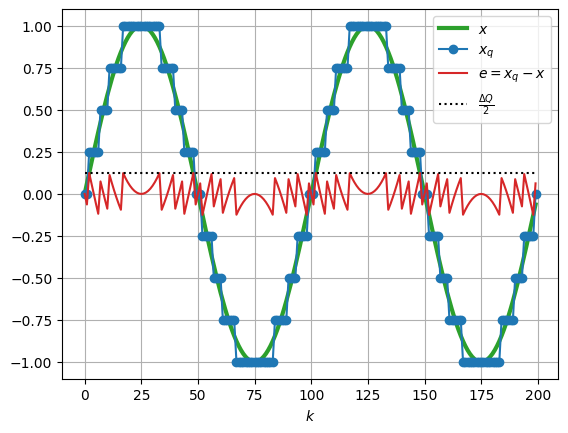

In [12]:
Q = 9  # odd, number of quantization steps
N = 100
k = np.arange(2*N)
x = np.sin(2*np.pi/N*k)
xq = my_quant(x, Q)
e = xq-x
# actually stem plots would be correct, for convenience we plot as line style
plt.plot(k, x, 'C2', lw=3, label=r'$x$')
plt.plot(k, xq, 'C0o-', label=r'$x_q$')
plt.plot(k, e, 'C3', label=r'$e=x_q-x$')
plt.plot(k, k*0+1/(Q-1), 'k:', label=r'$\frac{\Delta Q}{2}$')
plt.xlabel(r'$k$')
plt.legend()
plt.grid(True)

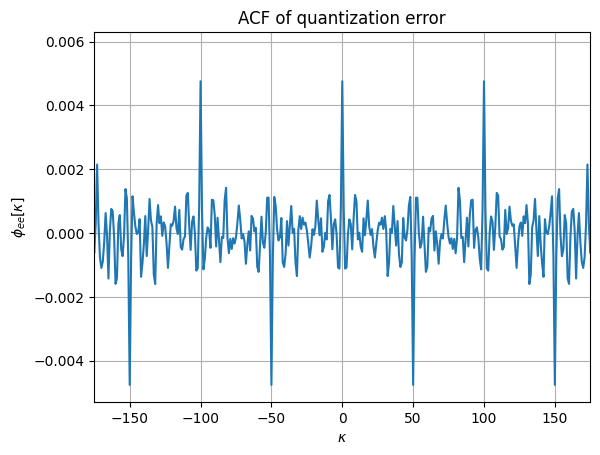

In [13]:
kappa, acf = my_xcorr2(e, e, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-175, +175)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{ee}[\kappa]$')
plt.title('ACF of quantization error')
plt.grid(True)

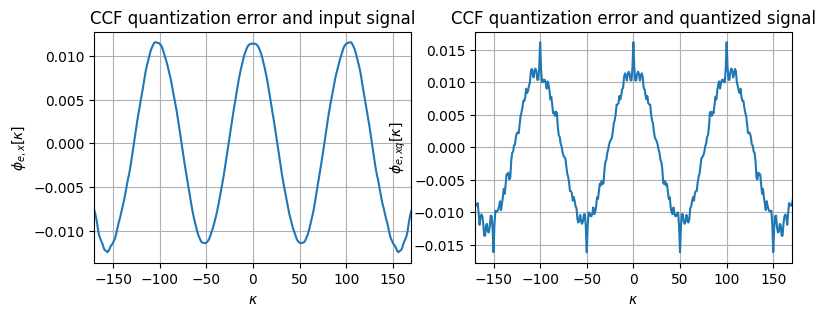

In [14]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
kappa, acf = my_xcorr2(e, x, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-170, +170)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{e,x}[\kappa]$')
plt.title('CCF quantization error and input signal')
plt.grid(True)

plt.subplot(1, 2, 2)
kappa, acf = my_xcorr2(e, xq, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-170, +170)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{e,xq}[\kappa]$')
plt.title('CCF quantization error and quantized signal')
plt.grid(True)

In [15]:
B = 16  # number of bits
Q = 2**B  # number of quantization steps

# for even Q only:
deltaQ = 2/Q
# maximum quantize value:
xqmax = 1-2**(-(B-1))
# or more general for even Q:
xqmax = 1-deltaQ

print(' B = %d bits\n quantization steps Q = %d\n quantization step size %e' %
      (B, Q, deltaQ))
print(' smallest quantization value xqmin = -1')
print(' largest quantization value xqmax = %16.15f' % xqmax)

 B = 16 bits
 quantization steps Q = 65536
 quantization step size 3.051758e-05
 smallest quantization value xqmin = -1
 largest quantization value xqmax = 0.999969482421875


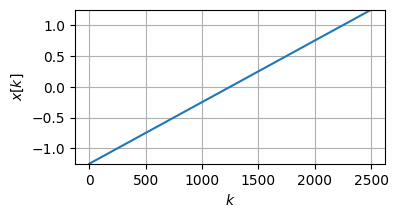

In [16]:
x = np.arange(-1.25, +1.25, 1e-3)
plt.figure(figsize=(4, 2))
plt.plot(x)  # actually a stem plot is correct
plt.ylim(-1.25, +1.25)
plt.xlabel(r'$k$')
plt.ylabel(r'$x[k]$')
plt.grid(True)

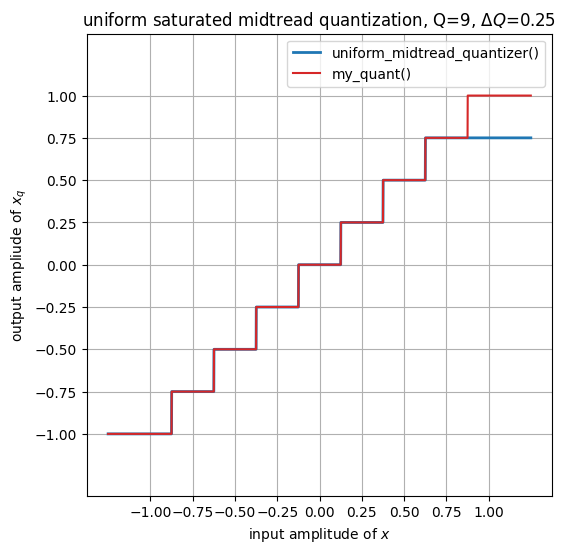

In [17]:
Q = 9  # number of quantization steps, odd or even
deltaQ = 1/(Q//2)  # quantization step size, even/odd Q

xq = my_quant(x, Q)  # used in exercise
xumq = uniform_midtread_quantizer(x, deltaQ)  # as used in lecture

plt.figure(figsize=(6, 6))
plt.plot(x, xumq, 'C0', lw=2, label='uniform_midtread_quantizer()')
plt.plot(x, xq, 'C3', label='my_quant()')
plt.xticks(np.arange(-1, 1.25, 0.25))
plt.yticks(np.arange(-1, 1.25, 0.25))
plt.xlabel(r'input amplitude of $x$')
plt.ylabel(r'output ampliude of $x_q$')
plt.title(
    r'uniform saturated midtread quantization, Q={0:d}, $\Delta Q$={1:3.2f}'.format(Q, deltaQ))
plt.axis('equal')
plt.legend()
plt.grid(True)

In [20]:
def check_my_quant(Q):
    N = 5e2
    x = 2*np.arange(N)/N - 1
    xq = my_quant(x, Q)
    e = xq - x

    plt.plot(x, x, color='C2', lw=3, label=r'$x[k]$')
    plt.plot(x, xq, color='C3', label=r'$x_q[k]$')
    plt.plot(x, e, color='C0', label=r'$e[k] = x_q[k] - x[k]$')
    plt.xticks(np.arange(-1, 1.25, 0.25))
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.xlabel('input amplitude')
    plt.ylabel('output amplitude')
    if np.mod(Q, 2) == 0:
        s = ' saturated '
    else:
        s = ' '
    plt.title(
        '' % (Q, 1/(Q//2)))
    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.grid(True)

TypeError: not all arguments converted during string formatting

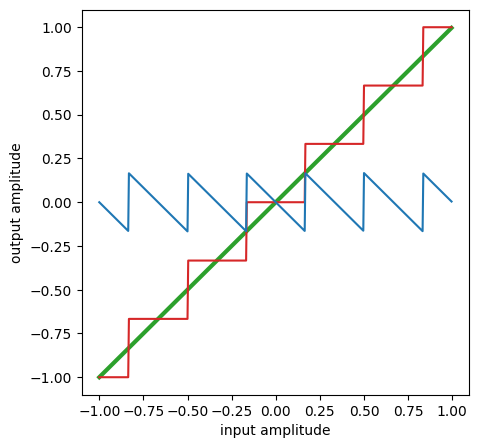

In [21]:
Q = 7  # number of quantization steps
deltaQ = 1 / (Q//2)  # general rule
deltaQ = 2 / (Q-1)  # for odd Q only
plt.figure(figsize=(5, 5))
check_my_quant(Q)

TypeError: not all arguments converted during string formatting

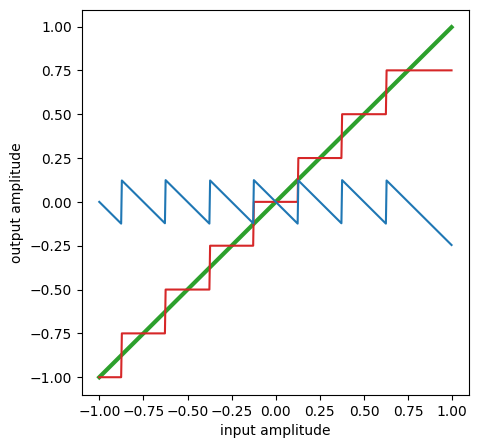

In [22]:
Q = 8  # number of quantization steps
deltaQ = 1 / (Q//2)  # general rule
deltaQ = 2 / Q  # for even Q only
plt.figure(figsize=(5, 5))
check_my_quant(Q)